# Problem Set 3: Text As Data
#### Submitted by Sahana Bhat

### Part 1: Set-up

In [321]:
import os
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer

import warnings
warnings.filterwarnings('ignore')

In [314]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [322]:
# extracting data from txt files
def filecontent_array(directoryPath):
    filenameList = []
    contentList = []
    for filename in os.listdir(directoryPath):
        file = open(directoryPath + filename, "r", encoding="utf8")
        filenameList.append(filename)
        content = file.read()
        contentList.append(content)
        file.close()
    contentdf = pd.DataFrame({'fileName':filenameList, 'content':contentList})
    return contentdf

In [487]:
train_set = []
test_set = []
train_set = filecontent_array('../575/train/')
test_set = filecontent_array('../575/test/')

### Note:
The training data consists of the Text and the Label. 
The test data consists of only Text which needs to be classified.
In the training set, the text and the label are separated.
The label is then updated to contain only the last name of the person as mentioned in Part 2 Question 12.

In [488]:
# sepearating the text and Labels
LabelList,train_set['content'] = train_set['content'].str.split(":", 1).str
# updating labels to last names as asked in Part 2 Question 12
LabelList = LabelList.str.split(" ", 1).str[1]
LabelList = [x.upper() for x in LabelList]


In [449]:
# checking if the labels are related to the respective file names
for i in range(len(LabelList)):
    if LabelList[i].lower() not in train_set['fileName'][i].lower():
        print(LabelList[i], train_set['fileName'][i])

We find that all the label names are related to the respective file names

### Preparing data:
The text content is cleaned by removing punctuation marks, stopwords.
The additional stop words removed are numerical digits [0-9] 
the text is also stemmed useing PorterStemmer to remove suffixes.

In [362]:
# preparing data by
# converting to lower-case 
# removing punctuation and stop words
def dataCleaning(data):
    TextContent = data['content']
    TextContent = TextContent.str.lower()
    TextContent = TextContent.str.replace('\n', ' ')
    TextContent = TextContent.str.replace('\t', ' ')
    TextContent = TextContent.str.replace(r"[^\w\s']", ' ')
    TextContent = TextContent.str.replace(r'[0-9]+', ' ')
    TextContent = TextContent.str.strip()
    # stemming
    stops = stopwords.words('english')
    stemmerPort = PorterStemmer()
    TextContent = TextContent.apply(lambda x: ' '.join([stemmerPort.stem(word) for word in x.split() if word not in stops]))
    return TextContent

In [496]:
TrainSet = dataCleaning(train_set)
TestSet = dataCleaning(test_set)

In [499]:
print("Before:")
print(train_set['content'][0])

Before:
 I refuse to postpone any longer taking on climate change and leading the world in taking on climate change. Look, this is the United States of America, there’s never been a single solitary time when we’ve set our mind to something and we’ve not able to do it. We’re walking around with our heads down like, “Woe is me.” We’re the best equipped nation in the world to take this on, it’s no longer time to postpone, we should get moving. There’s enormous, enormous opportunities once we get rid of Donald Trump.


In [500]:
print("After:")
print(TrainSet[0])

After:
refus postpon longer take climat chang lead world take climat chang look unit state america never singl solitari time set mind someth abl walk around head like woe best equip nation world take longer time postpon get move enorm enorm opportun get rid donald trump


### Comparing Before and After:
We see that there is a significant difference in the text when data is cleaned is applied.
The stop words such as I, to, we, our, etc are removed
The suffix of the words has been removed by stemming. For example: 'refuse' has become 'refus' 

### Tokenizing data using CountVectorizer:
To have the same dimensions for your training and test data. 
sklearn's CountVectorizer is used to fit on the training data and transform the test data.

The parameter 'min_df' has been set to 3. This corresponds to the minimum number of documents that should contain this feature. So we only include those words that occur in at least 3 documents. 

Similarly, for the 'max_df', feature the value is set to 0.9; in which the fraction corresponds to a percentage. Here 0.9 means that we should include only those words that occur in a maximum of 90% of all the documents.

The number of unique tokens are 1459.

In [408]:
vectorizer = CountVectorizer(max_features=3000, min_df=3, max_df=0.90, stop_words=stopwords.words('english'))
vectorizer.fit(TrainSet)

X_train_CV = vectorizer.transform(TrainSet).toarray()
X_test_CV = vectorizer.transform(TestSet).toarray()

In [502]:
print(X_train_CV.shape)
print(X_test_CV.shape)

(528, 1459)
(111, 1459)


We see that the number of features are the same for both Train ans Test data.
The number of unique tokens are 1459.

### Part 2: Supervised Learning

In [345]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.naive_bayes import MultinomialNB

import xgboost, numpy, string
from textblob import TextBlob

### Additional features:
The following additional features are added:
1. Bi-grams
2. TF-IDF weights

To find the most important features for higher accuracy, various combination of fetaures were tried.
The best results were obtained when all these features were combined together.

The final train set consists of all these features combined horizontally, keeping the number of rows unchanged.

Although, I tried to calaculate sentiment of the text using TextBlob, I didnt find it a relevant feature to be included

In [410]:
# bi-grams
cv2gram = CountVectorizer(max_features=3000, min_df=3, max_df=0.9, stop_words=stopwords.words('english'),ngram_range=(2,2))
cv2gram.fit(TrainSet)
X_train_CV2gram = cv2gram.transform(TrainSet).toarray()
X_test_CV2gram = cv2gram.transform(TestSet).toarray()

In [411]:
#TF-IDF
tfidfconverter = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95, stop_words=stopwords.words('english'))
tfidfconverter.fit(TrainSet)
X_train_tfidf = tfidfconverter.transform(TrainSet).toarray()
X_test_tfidf = tfidfconverter.transform(TestSet).toarray()

In [412]:
#sentiment 
train_set['sentiment'] = [TextBlob(str(x)).sentiment[0] for x in TrainSet ]
test_set['sentiment'] = [TextBlob(str(x)).sentiment[0] for x in TestSet ]

In [435]:
# horizontally concatinating all the feature vectors
X_train_Combined = np.hstack((X_train_CV,X_train_CV2gram,X_train_tfidf))
X_test_Combined = np.hstack((X_test_CV,X_test_CV2gram, X_test_tfidf))

In [503]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_Combined, LabelList, test_size=0.25, random_state=0)

### Regularized Logistic Regression model

In the sklearn.linear_model.LogisticRegression, regularization is applied by default.

Hyperparameters selected:
1. Random_state=5, The seed of the pseudo random number generator to use when shuffling the data.
2. Solver = ‘lbfgs’, these solvers support only L2 regularization
3. max_iter = 1000, Maximum number of iterations taken for the solvers to converge

In [515]:
# fit the training dataset on the classifier
Logistic_regression_classifier = linear_model.LogisticRegression(random_state = 5, max_iter = 1000, solver = 'lbfgs')
Logistic_regression_classifier.fit(X_train, y_train)

# predict the labels on validation dataset
predictions = Logistic_regression_classifier.predict(X_test)
print("Accuracy of Logistic Regression model = " + str(metrics.accuracy_score(predictions, y_test)))
    
print("Classes : ")
print(classifier.classes_)

print("Regularization intercept: ")
print(classifier.intercept_)
print("Regularization coefficient: ")
print(classifier.coef_)


Accuracy of Logistic Regression model = 0.5606060606060606
Classes : 
['BIDEN' 'BOOKER' 'BUTTIGIEG' 'CASTRO' 'GABBARD' 'HARRIS' 'KLOBUCHAR'
 "O'ROURKE" 'SANDERS' 'STEYER' 'WARREN' 'YANG']
Regularization intercept: 
[-1.52254353 -1.71501837 -1.68777841 -1.82439286 -2.11532361 -1.90091739
 -1.8878804  -1.89553211 -1.65417446 -2.0298632  -1.42689088 -1.70236973]
Regularization coefficient: 
[[-0.08888171  0.33361796 -0.03381335 ...  0.00482792 -0.00417324
  -0.00715965]
 [-0.15147476 -0.27367814 -0.03780931 ... -0.01710281 -0.00505073
  -0.00164573]
 [-0.02572875 -0.24542366 -0.06319908 ... -0.0115691  -0.00503248
  -0.0022465 ]
 ...
 [-0.02528674 -0.18838467 -0.00907024 ...  0.00911693 -0.00120584
  -0.00205885]
 [-0.20791059  0.13941327  0.42131136 ... -0.00846168 -0.0010855
   0.00465441]
 [-0.0397074  -0.16888557 -0.00452648 ...  0.01030243  0.01572841
  -0.00098499]]


Classification_report: 
              precision    recall  f1-score   support

       BIDEN       0.59      0.77      0.67        13
      BOOKER       0.50      0.54      0.52        13
   BUTTIGIEG       0.43      0.56      0.49        16
      CASTRO       1.00      0.29      0.44         7
     GABBARD       0.50      0.25      0.33         4
      HARRIS       1.00      0.40      0.57        10
   KLOBUCHAR       0.50      0.90      0.64        10
    O'ROURKE       1.00      0.40      0.57         5
     SANDERS       0.53      0.50      0.52        16
      STEYER       0.71      0.71      0.71         7
      WARREN       0.57      0.76      0.65        21
        YANG       0.50      0.10      0.17        10

    accuracy                           0.56       132
   macro avg       0.65      0.52      0.52       132
weighted avg       0.61      0.56      0.54       132

Confusion matrix: 


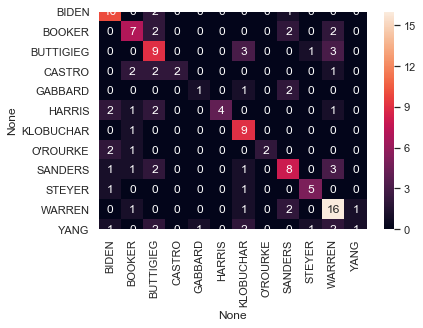

In [516]:
print("Classification_report: ")
print(classification_report(y_test, predictions))

print("Confusion matrix: ")
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [Logistic_regression_classifier.classes_],
                  columns = [Logistic_regression_classifier.classes_])
sn.set(font_scale=1) 
sn.heatmap(df_cm, annot=True,  annot_kws={"size": 12})


### Inference:
Accuracy of Logistic Regression model = 0.56

By analyzing at the Classification_report, the precision, recall and f1-score suggest that:
1. Classification for Labels: YANG, CASTRO, GABBARD are weaker
2. Classification for Labels:WARREN, KLOBUCHAR, BUTTIGIEG are stronger


### Xgboost Classifier
XGBoost Classifier works on the concept of decision tree ensembles. The tree ensemble model consists of a set of classification and regression trees (CART).

To build the model, I tried to user hyper parameters, such as:
1. learning_rate = 0.01, step size shrinkage used to prevent overfitting. Range is [0,1]
2. max_depth = 5,  determines how deeply each tree is allowed to grow during any boosting round.
3. n_estimators = 1000 number of trees you want to build.

But these did not improve the model and instead took more time to compute. Hence, I have decided to not use any hyper parameters fro tuning the model.

In [259]:
import xgboost

Accuracy of XGBoost model = 0.38636363636363635
Classification_report: 
              precision    recall  f1-score   support

       BIDEN       0.48      0.77      0.59        13
      BOOKER       0.31      0.38      0.34        13
   BUTTIGIEG       0.25      0.31      0.28        16
      CASTRO       1.00      0.29      0.44         7
     GABBARD       0.00      0.00      0.00         4
      HARRIS       0.43      0.30      0.35        10
   KLOBUCHAR       0.25      0.40      0.31        10
    O'ROURKE       0.33      0.20      0.25         5
     SANDERS       0.56      0.31      0.40        16
      STEYER       0.14      0.14      0.14         7
      WARREN       0.52      0.67      0.58        21
        YANG       0.33      0.10      0.15        10

    accuracy                           0.39       132
   macro avg       0.38      0.32      0.32       132
weighted avg       0.41      0.39      0.37       132

Confusion matrix: 


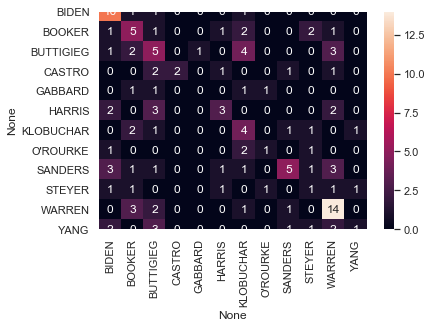

In [517]:
# XGBoost
XGBoost_classifier = xgboost.XGBClassifier()
XGBoost_classifier.fit(X_train, y_train)

# predict the labels on validation dataset
predictions = XGBoost_classifier.predict(X_test)
    

print("Accuracy of XGBoost model = " + str(metrics.accuracy_score(predictions, y_test)))

print("Classification_report: ")
print(classification_report(y_test, predictions))

print("Confusion matrix: ")
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [XGBoost_classifier.classes_],
                  columns = [XGBoost_classifier.classes_])
sn.set(font_scale=1) 
sn.heatmap(df_cm, annot=True,  annot_kws={"size": 12})

#### Inference:
The Accuracy of the model = 0.4375 

Based on the classification report, we see that the model has not performed as well as the Logistic regression model in predicting the results. 

By analyzing at the Classification_report, the precision, recall and f1-score suggest that:
1. Classification for Labels: YANG, CASTRO, GABBARD are weaker
2. Classification for Labels:WARREN, KLOBUCHAR, BUTTIGIEG are stronger


### Support Vector Classifier

SVM also has some hyper-parameters (like what C or gamma values to use) and finding optimal hyper-parameter is a very hard task to solve. But it can be found by just trying all combinations and see what parameters work best. The main idea behind it is to create a grid of hyper-parameters and just try all of their combinations (hence, this method is called Gridsearch, But don’t worry! we don’t have to do it manually because Scikit-learn has this functionality built-in with GridSearchCV.

One of the great things about GridSearchCV is that it is a meta-estimator. It takes an estimator like SVC, and creates a new estimator, that behaves exactly the same – in this case, like a classifier. You should add refit=True and choose verbose to whatever number you want, higher the number, the more verbose (verbose just means the text output describing the process).

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.149, total=   2.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.152, total=   2.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.154, total=   2.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.149, total=   2.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.152, total=   2.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.154, total=   2.9s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.149, total=   2.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.152, total=   2.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.154, total=   2.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.149, total=   2.7s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.152, total=   2.8s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.154, total=   2.9s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.149, total=   2.7s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.152, total=   2.7s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.154, total=   2.9s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=1000, gamma=0.01, kernel=rbf, score=0.344, total=   2.7s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.3min finished


Accuracy: 0.45
Classification_report: 
              precision    recall  f1-score   support

       BIDEN       0.38      0.71      0.50         7
      BOOKER       0.57      0.67      0.62         6
   BUTTIGIEG       0.29      0.50      0.36         8
      CASTRO       0.75      0.50      0.60         6
     GABBARD       0.00      0.00      0.00         3
      HARRIS       0.50      0.17      0.25         6
   KLOBUCHAR       0.43      0.38      0.40         8
    O'ROURKE       0.50      0.25      0.33         4
     SANDERS       0.30      0.30      0.30        10
      STEYER       1.00      0.25      0.40         4
      WARREN       0.56      0.83      0.67        12
        YANG       0.00      0.00      0.00         6

    accuracy                           0.44        80
   macro avg       0.44      0.38      0.37        80
weighted avg       0.44      0.44      0.40        80

Confusion matrix: 


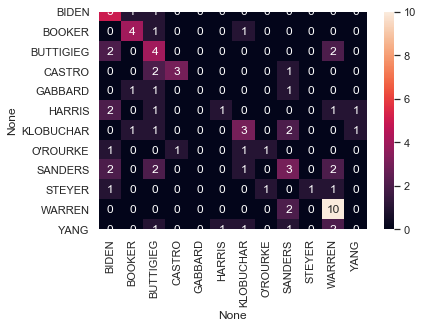

In [432]:

#Import svm model
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

#Create a svm Classifier
#clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
#clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = grid.predict(X_test)



Accuracy: 0.45
Classification_report: 
              precision    recall  f1-score   support

       BIDEN       0.38      0.71      0.50         7
      BOOKER       0.57      0.67      0.62         6
   BUTTIGIEG       0.29      0.50      0.36         8
      CASTRO       0.75      0.50      0.60         6
     GABBARD       0.00      0.00      0.00         3
      HARRIS       0.50      0.17      0.25         6
   KLOBUCHAR       0.43      0.38      0.40         8
    O'ROURKE       0.50      0.25      0.33         4
     SANDERS       0.30      0.30      0.30        10
      STEYER       1.00      0.25      0.40         4
      WARREN       0.56      0.83      0.67        12
        YANG       0.00      0.00      0.00         6

    accuracy                           0.44        80
   macro avg       0.44      0.38      0.37        80
weighted avg       0.44      0.44      0.40        80

Confusion matrix: 


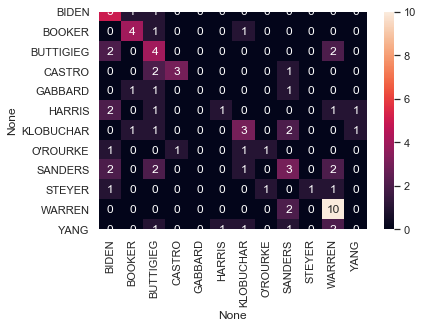

In [434]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("Classification_report: ")
print(classification_report(y_test, predictions))

print("Confusion matrix: ")
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [classifier.classes_],
                  columns = [classifier.classes_])
sn.set(font_scale=1) 
sn.heatmap(df_cm, annot=True,  annot_kws={"size": 12})

To inspect the best parameters found by GridSearchCV in the best_params_ attribute, and the best estimator in the best_estimator_ attribute:

In [433]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


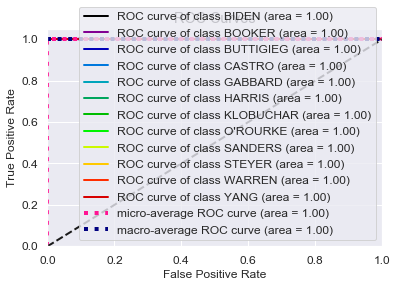

In [509]:
import scikitplot as skplt
from scikitplot.metrics import plot_roc_curve

y_probas = classifier.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

#### Inference:

From the results obtained:
The Accuracy of the model = 0.4375 

Based on the classification report, we see that the model has not performed as well as the Logistic regression model in predicting the results. 

By analyzing at the Classification_report, the precision, recall and f1-score suggest that:
1. Classification for Labels: YANG, CASTRO, GABBARD are weaker
2. Classification for Labels:WARREN, KLOBUCHAR, BUTTIGIEG are stronger

### Part 3: Semi-Supervised Learning

The model selected is the LogisticRegression model. I have selected it, as it's faster and less complicated

In [494]:
# fit the training dataset on the classifier

classifier = linear_model.LogisticRegression()

X_train_new = X_train_Combined
X_test_new = X_train_Combined
LabelList_new = LabelList
AccuracyList = []

classifier.fit(X_train_new, LabelList_new)
# Using K-crossfold method to evaluate the model
scores = cross_val_score(classifier, X_train_new, LabelList_new, cv=5)
AccuracyList.append(scores.mean())



In [495]:
for x in range(10):  
    #To get the top 10% values with higher predicted probablity
    probs = classifier.predict_proba(X_test_new)
    top_picks_indexes = probs[:,1].argsort()[-11:]
    y_pred = classifier.predict(X_test_new)
    # updating the Labellist with predicted values
    LabelList_new = LabelList_new + pd.Series(y_pred[top_picks_indexes]).tolist()
    # updating training set with top 11 values from test
    X_train_new = np.concatenate([X_train_new,X_test_new[top_picks_indexes]])
    classifier.fit(X_train_new, LabelList_new)
    scores = cross_val_score(classifier, X_train_new, LabelList_new, cv=5)
    AccuracyList.append(scores.mean())
print(AccuracyList)

[0.5260195239024676, 0.5432102351368406, 0.5506614489591497, 0.5561823052458663, 0.5647590429084637, 0.5629186382117064, 0.5728237138226165, 0.5807846336526514, 0.5865699110924917, 0.5937329435321114, 0.597711048286339]


Text(0, 0.5, 'Accuracy of prediction')

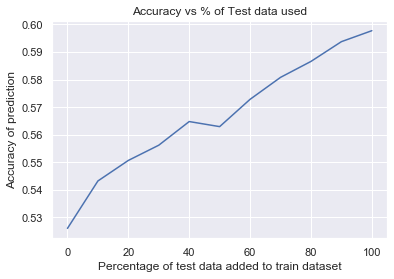

In [521]:
X = [0, 10, 20, 30, 40 , 50, 60, 70, 80, 90, 100]
plt.plot(X, AccuracyList)
plt.title('Accuracy vs % of Test data used')
plt.xlabel('Percentage of test data added to train dataset')
plt.ylabel('Accuracy of prediction')

In [531]:
# filename
fileNameList = test_set['fileName'].tolist()
#Model1 prediction:
predictions_Model1 = Logistic_regression_classifier.predict(X_test_Combined).tolist()
#Model2 prediction:
predictions_Model2 = classifier.predict(X_test_Combined).tolist()
df = pd.DataFrame({'fileName': fileNameList, 'Model1':predictions_Model1, 'Model2':predictions_Model2})
df

,fileName,Model1,Model2
0,test_1.txt,WARREN,WARREN
1,test_10.txt,WARREN,WARREN
2,test_100.txt,WARREN,BIDEN
3,test_101.txt,WARREN,HARRIS
4,test_102.txt,BUTTIGIEG,BUTTIGIEG
...,...,...,...
106,test_95.txt,HARRIS,HARRIS
107,test_96.txt,BOOKER,BOOKER
108,test_97.txt,HARRIS,HARRIS
109,test_98.txt,KLOBUCHAR,KLOBUCHAR


In [535]:
# saving values in the result file
np.savetxt('Result.txt', df.values,fmt='%s', delimiter="\t", header="FILE\tMODEL1\tMODEL2")  